# Overview
- モデルの評価の仕方を考える

In [1]:
import subprocess
cmd = "git rev-parse --short HEAD"
hash = subprocess.check_output(cmd.split()).strip().decode('utf-8')
print(hash)

4366032


# Const

In [2]:
NB = '007'
DIR_TRAIN = './../data_ignore/input/train/'
DIR_TEST = './../data_ignore/input/test/'
DIR_WIFI = './../data_ignore/input/wifi/'
PATH_SUB = './../data_ignore/input/sample_submission.csv'
PATH_99_SUB = './../data/input/floor_99per_acc_sub.csv'
DIR_SAVE_IGNORE = f'./../data_ignore/nb/{NB}/'
DIR_SAVE = f'./../data/nb/{NB}/'

In [3]:
config_str = '''
globals:
    seed: 5713
    device: cuda
    n_label: 24
    n_splits: 5
    random_sate: 42
    lr: 0.001
    patience: 10
    epoch: 100
    batch_size: 512
    skip_evaluate_num: 5
    num_feats: 20
    t_mux: 10
'''

# Import everything I need:)

In [27]:
import os
import time
import yaml
import types
import random
import pickle
import builtins
import numpy as np
import pandas as pd
import seaborn as sns
from icecream import ic
import matplotlib.pyplot as plt
import pytablewriter
from dataclasses import dataclass
# from tqdm import tqdm
from fastprogress import progress_bar, master_bar
from glob import glob
from loguru import logger
from collections import OrderedDict

# sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold

# pytorch
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

# Function

In [5]:
def imports():
    for name, val in globals().items():
        # module imports
        if isinstance(val, types.ModuleType):
            yield name, val

            # functions / callables
        if hasattr(val, '__call__'):
            yield name, val


def noglobal(f):
    '''
    ref: https://gist.github.com/raven38/4e4c3c7a179283c441f575d6e375510c
    '''
    return types.FunctionType(f.__code__,
                              dict(imports()),
                              f.__name__,
                              f.__defaults__,
                              f.__closure__
                              )


def comp_metric(xhat, yhat, fhat, x, y, f):
    intermediate = np.sqrt(np.power(xhat-x, 2) + np.power(yhat-y, 2)) + 15 * np.abs(fhat-f)
    return intermediate.sum()/xhat.shape[0]

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [6]:
@dataclass
class ReadData:
    acce: np.ndarray
    acce_uncali: np.ndarray
    gyro: np.ndarray
    gyro_uncali: np.ndarray
    magn: np.ndarray
    magn_uncali: np.ndarray
    ahrs: np.ndarray
    wifi: np.ndarray
    ibeacon: np.ndarray
    waypoint: np.ndarray


def read_data_file(data_filename):
    acce = []
    acce_uncali = []
    gyro = []
    gyro_uncali = []
    magn = []
    magn_uncali = []
    ahrs = []
    wifi = []
    ibeacon = []
    waypoint = []

    with open(data_filename, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    for line_data in lines:
        line_data = line_data.strip()
        if not line_data or line_data[0] == '#':
            continue

        line_data = line_data.split('\t')

        if line_data[1] == 'TYPE_ACCELEROMETER':
            acce.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_ACCELEROMETER_UNCALIBRATED':
            acce_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_GYROSCOPE':
            gyro.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_GYROSCOPE_UNCALIBRATED':
            gyro_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_MAGNETIC_FIELD':
            magn.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_MAGNETIC_FIELD_UNCALIBRATED':
            magn_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_ROTATION_VECTOR':
            ahrs.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_WIFI':
            sys_ts = line_data[0]
            ssid = line_data[2]
            bssid = line_data[3]
            rssi = line_data[4]
            lastseen_ts = line_data[6]
            wifi_data = [sys_ts, ssid, bssid, rssi, lastseen_ts]
            wifi.append(wifi_data)
            continue

        if line_data[1] == 'TYPE_BEACON':
            ts = line_data[0]
            uuid = line_data[2]
            major = line_data[3]
            minor = line_data[4]
            rssi = line_data[6]
            ibeacon_data = [ts, '_'.join([uuid, major, minor]), rssi]
            ibeacon.append(ibeacon_data)
            continue

        if line_data[1] == 'TYPE_WAYPOINT':
            waypoint.append([int(line_data[0]), float(line_data[2]), float(line_data[3])])

    acce = np.array(acce)
    acce_uncali = np.array(acce_uncali)
    gyro = np.array(gyro)
    gyro_uncali = np.array(gyro_uncali)
    magn = np.array(magn)
    magn_uncali = np.array(magn_uncali)
    ahrs = np.array(ahrs)
    wifi = np.array(wifi)
    ibeacon = np.array(ibeacon)
    waypoint = np.array(waypoint)

    return ReadData(acce, acce_uncali, gyro, gyro_uncali, magn, magn_uncali, ahrs, wifi, ibeacon, waypoint)

In [7]:
class IndoorWiFiNet(nn.Module):
    def __init__(self, bssid_size, site_size, num_feats):
        super(IndoorWiFiNet, self).__init__()
        self.bssid_embedding = nn.Embedding(bssid_size, 64, max_norm=True)
        self.site_embedding = nn.Embedding(site_size, 64, max_norm=True)

        self.rssi = nn.Sequential(
            nn.BatchNorm1d(20),
            nn.Linear(20, num_feats * 64)
        )

        concat_size = 64 + (num_feats * 64) + (num_feats * 64)
        self.bn1 = nn.BatchNorm1d(concat_size)

        self.flatten = nn.Flatten()

        self.dropout1 = nn.Dropout(0.3)
        self.linear1 = nn.Linear(in_features=concat_size, out_features=256)#, bias=False)
        self.bn2 = nn.BatchNorm1d(256)

        self.linear2 = nn.Linear(in_features=256, out_features=128)#, bias=False)
        self.linear3 = nn.Linear(in_features=128, out_features=16)#, bias=False)

        self.bn3 = nn.BatchNorm1d(128)
        self.bn4 = nn.BatchNorm1d(16)


        self.xy = nn.Linear(in_features=16, out_features=2)#, bias=False)
        self.floor = nn.Linear(in_features=16, out_features=1)#, bias=False)
        

    def forward(self, bssid, rssi, site):

        site = torch.reshape(site, (-1, 1))

        bssid_out = self.bssid_embedding(bssid)
        site_out = self.site_embedding(site)

        rssi_out = self.rssi(rssi)

        bssid_out = self.flatten(bssid_out)
        site_out = self.flatten(site_out)

        x = torch.cat([bssid_out, rssi_out, site_out], dim=1)
        x = self.bn1(x)
        x = self.dropout1(x)
        x = F.relu(self.linear1(x))
        x = self.bn2(x)

        x = F.relu(self.linear2(x))
        x = self.bn3(x)

        x = F.relu(self.linear3(x))
        x = self.bn4(x)

        #x = self.lstm(x)

        xy = self.xy(x)
        floor = self.floor(x)

        return xy, floor

In [8]:
class IndoorWiFiDataSet(Dataset):
    def __init__(self, wifi_df, bssid_feats_, rssi_feats_, data_type='test'):
        self.wifi_df = wifi_df
        self.data_type = data_type
        self.bssids = wifi_df[bssid_feats_].to_numpy().astype(np.int)    # <----- リファクタ
        self.rssis = wifi_df[rssi_feats_].to_numpy().astype(np.float)    # <----- リファクタ
        self.site_ids = wifi_df['site_id'].to_numpy()
        if data_type in ['train', 'valid']:
            self.floors = wifi_df['floor'].to_numpy().astype(np.int)
            self.xs = wifi_df['x'].to_numpy()
            self.ys = wifi_df['y'].to_numpy()
        
    def __len__(self):
        return len(self.wifi_df)

    def __getitem__(self, idx):

        #wifi_row = self.wifi_df.iloc[idx]

        bssid = self.bssids[idx,:]
        rssi = self.rssis[idx,:]
        site_id = self.site_ids[idx]

        if self.data_type in ['test', 'valid']:
            return bssid, rssi, site_id

        elif self.data_type == 'train':
            x = self.xs[idx]
            y = self.ys[idx]
            floor = self.floors[idx]

            return bssid, rssi, site_id, x, y, floor


# Preparation

load config

In [9]:
config = yaml.safe_load(config_str)
config

{'globals': {'seed': 5713,
  'device': 'cuda',
  'n_label': 24,
  'n_splits': 5,
  'random_sate': 42,
  'lr': 0.001,
  'patience': 10,
  'epoch': 100,
  'batch_size': 512,
  'skip_evaluate_num': 5,
  'num_feats': 20,
  't_mux': 10}}

<br>

set

In [10]:
seed_everything(config['globals']['seed'])
pd.set_option('display.max_rows', 500)

if not os.path.exists(DIR_SAVE_IGNORE):
    os.makedirs(DIR_SAVE_IGNORE)
if not os.path.exists(DIR_SAVE):
    os.makedirs(DIR_SAVE)

<br>

load dataset

In [11]:
with open(f'{DIR_WIFI}train_all.pkl', 'rb') as f:
    df_train = pickle.load( f)
with open(f'{DIR_WIFI}test_all.pkl', 'rb') as f:
    df_test = pickle.load( f)

sample_submission = pd.read_csv(PATH_SUB)

<br>

preprocessing

In [12]:
bssid_feats = [f'bssid_{i}' for i in range(config['globals']['num_feats'])]
rssi_feats  = [f'rssi_{i}' for i in range(config['globals']['num_feats'])]

In [13]:
# bssidの一覧作成
# wifi_bassidにはtrainとtest両方のbssidの一覧が含まれる

wifi_bssids = []
for i in range(100):
    wifi_bssids.extend(df_train.iloc[:,i].values.tolist())
wifi_bssids = list(set(wifi_bssids))

wifi_bssids_size = len(wifi_bssids)
print(f'BSSID TYPES: {wifi_bssids_size}')

wifi_bssids_test = []
for i in range(100):
    wifi_bssids_test.extend(df_test.iloc[:,i].values.tolist())
wifi_bssids_test = list(set(wifi_bssids_test))

wifi_bssids_size = len(wifi_bssids_test)
print(f'BSSID TYPES: {wifi_bssids_size}')

wifi_bssids.extend(wifi_bssids_test)
wifi_bssids_size = len(wifi_bssids)
print(f'BSSID TYPES: {wifi_bssids_size}')

BSSID TYPES: 61206
BSSID TYPES: 33042
BSSID TYPES: 94248


In [14]:
# LabelEncoding & StandardScaler

le = LabelEncoder()
le.fit(wifi_bssids)
le_site = LabelEncoder()
le_site.fit(df_train['site_id'])

ss = StandardScaler()
ss.fit(df_train.loc[:, rssi_feats])

StandardScaler()

In [15]:
df_train.loc[:, rssi_feats] = ss.transform(df_train.loc[:, rssi_feats])
df_test.loc[:, rssi_feats] = ss.transform(df_test.loc[:, rssi_feats])
for feat in bssid_feats:
    df_train.loc[:, feat] = le.transform(df_train.loc[:, feat])
    df_test.loc[:, feat] = le.transform(df_test.loc[:, feat])
    
    df_train.loc[:, feat] = df_train.loc[:, feat] + 1
    df_test.loc[:, feat] = df_test.loc[:, feat] + 1
    
df_train.loc[:, 'site_id'] = le_site.transform(df_train.loc[:, 'site_id'])
df_test.loc[:, 'site_id'] = le_site.transform(df_test.loc[:, 'site_id'])

df_train.loc[:, rssi_feats] = ss.transform(df_train.loc[:, rssi_feats])
df_test.loc[:, rssi_feats] = ss.transform(df_test.loc[:, rssi_feats])

In [16]:
site_count = len(df_train['site_id'].unique())
df_train.reset_index(drop=True, inplace=True)

In [17]:
df_train.head()

,bssid_0,bssid_1,bssid_2,bssid_3,bssid_4,bssid_5,bssid_6,bssid_7,bssid_8,bssid_9,...,rssi_95,rssi_96,rssi_97,rssi_98,rssi_99,x,y,floor,path,site_id
0,52393,35871,2765,34898,52710,35260,42720,33510,23417,15249,...,-79,-79,-79,-79,-79,107.85044,161.89262,-1,5e1580adf4c3420006d520d4,0
1,35871,52393,7487,34898,52710,35260,21971,15249,17025,5351,...,-79,-79,-79,-80,-80,107.85044,161.89262,-1,5e1580adf4c3420006d520d4,0
2,35871,52393,52710,34898,35260,23417,49408,6673,7487,48501,...,-77,-78,-78,-78,-78,98.33065,163.34334,-1,5e1580adf4c3420006d520d4,0
3,23417,34898,35260,52393,35871,3707,49408,15613,10167,4978,...,-75,-76,-76,-77,-77,98.33065,163.34334,-1,5e1580adf4c3420006d520d4,0
4,35871,35260,23417,19473,52393,3707,49408,18306,21410,52795,...,-75,-76,-76,-77,-77,98.33065,163.34334,-1,5e1580adf4c3420006d520d4,0


# Calc oof

In [18]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device(config['globals']['device'])

In [19]:
%%time

oof_x = np.zeros((len(df_train)))
oof_y = np.zeros((len(df_train)))
oof_floor = np.zeros((len(df_train)))
cv_scores = {}

kf = KFold(n_splits=config['globals']['n_splits'], random_state=42, shuffle=True)
for fold, (_, valid_index) in enumerate(kf.split(df_train)):
    print(f'\r\n====== {fold + 1} ======')
    net = IndoorWiFiNet(wifi_bssids_size, site_count, config['globals']['num_feats'])
    net = net.to(device)

    valid = df_train.iloc[valid_index]

    # TODO oof用のdataloaderはいらないはず
    valid_dataset = IndoorWiFiDataSet(valid.reset_index(drop=True), bssid_feats, rssi_feats, data_type='valid')
    validloader = DataLoader(valid_dataset, batch_size=config['globals']['batch_size'], num_workers=4)

    _x_oof = np.array([])
    _y_oof = np.array([])
    ############# OOF #############
    oof_preds = []
#     for i, (bssid, rssi, site_id) in tqdm(enumerate(validloader), total=len(validloader)):
    for i, (bssid, rssi, site_id) in enumerate(progress_bar(validloader)):
#         net.load_state_dict(torch.load(ROOT_DIR / Path('output') / f'checkpoint_{NB}_{fold}.pt'))
#         net.load_state_dict(torch.load(f'{DIR_SAVE_IGNORE}checkpoint_{NB}_{fold + 1}.pt'))
        net.load_state_dict(torch.load(f'./../data_ignore/nb/002/checkpoint_002_{fold}.pt'))
        net.eval()

        with torch.no_grad():

            bssid, rssi, site_id = bssid.to(device).long(), rssi.to(device).float(), site_id.to(device).long()

            xy_pred, floor_pred = net(bssid, rssi, site_id)

            xy_pred = xy_pred.to('cpu').detach().numpy().copy()
            x_pred, y_pred = np.hsplit(xy_pred, 2)
            _x_oof = np.concatenate([_x_oof, x_pred.reshape(-1)])
            _y_oof = np.concatenate([_y_oof, y_pred.reshape(-1)])

    print(comp_metric(_x_oof, _y_oof, 0, valid['x'], valid['y'], 0))

    oof_x[valid_index] = _x_oof
    oof_y[valid_index] = _y_oof

    del net
    torch.cuda.empty_cache()


====== 1 ======


5.955860050909875

====== 2 ======


3.2141416246866714

====== 3 ======


3.219628211192409

====== 4 ======


3.437314824066428

====== 5 ======


3.3353853712617956
CPU times: user 6.86 s, sys: 5.31 s, total: 12.2 s
Wall time: 13 s


In [20]:
oof_score = comp_metric(oof_x, oof_y, np.zeros(len(df_train)), df_train['x'], df_train['y'], np.zeros(len(df_train)))
oof_score

3.832466016423436

# Evaluate

In [21]:
df_train.head()

,bssid_0,bssid_1,bssid_2,bssid_3,bssid_4,bssid_5,bssid_6,bssid_7,bssid_8,bssid_9,...,rssi_95,rssi_96,rssi_97,rssi_98,rssi_99,x,y,floor,path,site_id
0,52393,35871,2765,34898,52710,35260,42720,33510,23417,15249,...,-79,-79,-79,-79,-79,107.85044,161.89262,-1,5e1580adf4c3420006d520d4,0
1,35871,52393,7487,34898,52710,35260,21971,15249,17025,5351,...,-79,-79,-79,-80,-80,107.85044,161.89262,-1,5e1580adf4c3420006d520d4,0
2,35871,52393,52710,34898,35260,23417,49408,6673,7487,48501,...,-77,-78,-78,-78,-78,98.33065,163.34334,-1,5e1580adf4c3420006d520d4,0
3,23417,34898,35260,52393,35871,3707,49408,15613,10167,4978,...,-75,-76,-76,-77,-77,98.33065,163.34334,-1,5e1580adf4c3420006d520d4,0
4,35871,35260,23417,19473,52393,3707,49408,18306,21410,52795,...,-75,-76,-76,-77,-77,98.33065,163.34334,-1,5e1580adf4c3420006d520d4,0


<br>

xyf毎

In [22]:
def calc_metrics_xyf(xhat, yhat, fhat, x, y, f):
    len_x = len(xhat)
    intermediate = np.sqrt(np.power(xhat-x, 2) + np.power(yhat-y, 2)) + 15 * np.abs(fhat-f)
    x_score = np.sqrt(np.power(xhat - x, 2)).sum() / len_x
    y_score = np.sqrt(np.power(yhat - y, 2)).sum() / len_x
    f_score = (15 * np.abs(fhat - f)).sum() / len_x
    
    df_result = pd.DataFrame({
        'name': ['all', 'x', 'y', 'f'],
        'score': [intermediate.sum()/len_x, x_score, y_score, f_score]
    })
    return df_result

In [109]:
df_result_xyf = calc_metrics_xyf(oof_x, oof_y, np.zeros(len(df_train)), df_train['x'], df_train['y'], np.zeros(len(df_train)))
df_result_xyf.style.bar(subset=['score'], color=['teal'])

,name,score
0,all,3.832466
1,x,2.443112
2,y,2.434019
3,f,0.000000


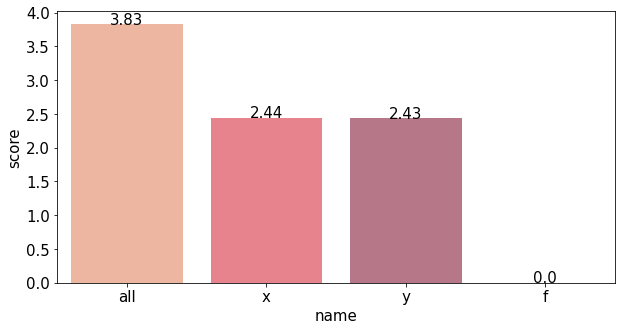

In [135]:
plt.rcParams['font.size'] = 15
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
bar = sns.barplot(data=df_result_xyf, x='name', y='score', ax=ax, palette=['#f8b195', '#f67280', '#c06c84', '#6c5b7b', '#355c7d'])
for index, row in df_result_xyf.iterrows():
    bar.text(row.name, row.score, round(row.score, 2), color='black', ha="center")

<br>

site毎

In [49]:
site_arr = le_site.inverse_transform(df_train.site_id)

In [58]:
@noglobal
def calc_metrics_site(x_pred, y_pred, f_pred, x_true, y_true, f_true, site_arr):
    '''
    site_arrは、intじゃなくて、"B1", "F2"みたいな感じで入力
    site_arr = le_site.inverse_transform(df_train.site_id)
    '''
    site_unique = sorted(np.unique(site_arr))
    score_list = []
    n_sample = []
    for site in site_unique:
        logics = site_arr == site
        x_pred_, y_pred_, f_pred_ = x_pred[logics], y_pred[logics], f_pred[logics]
        x_true_, y_true_, f_true_, = x_true[logics], y_true[logics], f_true[logics]
        len_x = len(x_pred_)
        
        intermediate = np.sqrt(np.power(x_pred_-x_true_, 2) + np.power(y_pred_-y_true_, 2)) + 15 * np.abs(f_pred_-f_true_)
        
        score_list.append(intermediate.sum()/len_x)
        n_sample.append(len_x)
    
    df_result = pd.DataFrame({
        'site': site_unique,
        'n_sample': n_sample,
        'score': score_list,
    })
    return df_result

In [59]:
df_result_site = calc_metrics_site(oof_x, oof_y, np.zeros(len(df_train)), df_train['x'], df_train['y'], np.zeros(len(df_train)), site_arr)
df_result_site.style.bar(subset=['n_sample', 'score'], color=['teal'])

,site,n_sample,score
0,5a0546857ecc773753327266,9296,3.005664
1,5c3c44b80379370013e0fd2b,9737,4.339122
2,5d27075f03f801723c2e360f,23666,3.411062
3,5d27096c03f801723c31e5e0,9100,3.077105
4,5d27097f03f801723c320d97,10507,5.182976
5,5d27099f03f801723c32511d,4251,3.569656
6,5d2709a003f801723c3251bf,3940,2.778711
7,5d2709b303f801723c327472,15358,3.894781
8,5d2709bb03f801723c32852c,17203,4.589533
9,5d2709c303f801723c3299ee,10083,2.730841


In [60]:
@noglobal
def site_eval_report(df_result_site):
    df_result_site.insert(loc=0, column='No', value=df_result_site.index)
    writer = pytablewriter.MarkdownTableWriter()
    writer.from_dataframe(df_result_site)
    writer.write_table()

In [61]:
site_eval_report(df_result_site)

|No |          site          |n_sample|score|
|--:|------------------------|-------:|----:|
|  0|5a0546857ecc773753327266|    9296|3.006|
|  1|5c3c44b80379370013e0fd2b|    9737|4.339|
|  2|5d27075f03f801723c2e360f|   23666|3.411|
|  3|5d27096c03f801723c31e5e0|    9100|3.077|
|  4|5d27097f03f801723c320d97|   10507|5.183|
|  5|5d27099f03f801723c32511d|    4251|3.570|
|  6|5d2709a003f801723c3251bf|    3940|2.779|
|  7|5d2709b303f801723c327472|   15358|3.895|
|  8|5d2709bb03f801723c32852c|   17203|4.590|
|  9|5d2709c303f801723c3299ee|   10083|2.731|
| 10|5d2709d403f801723c32bd39|   10027|3.746|
| 11|5d2709e003f801723c32d896|   11042|4.510|
| 12|5da138274db8ce0c98bbd3d2|    2662|3.271|
| 13|5da1382d4db8ce0c98bbe92e|    8999|3.680|
| 14|5da138314db8ce0c98bbf3a0|    9012|3.093|
| 15|5da138364db8ce0c98bc00f1|    2767|2.392|
| 16|5da1383b4db8ce0c98bc11ab|   13196|4.611|
| 17|5da138754db8ce0c98bca82f|    7188|3.956|
| 18|5da138764db8ce0c98bcaa46|    9420|3.578|
| 19|5da1389e4db8ce0c98bd0547|    